# Newsgroup Semantic Analysis

**Project Overview**: In this project, I analyze unstructured text data from the "20 Newsgroups" dataset to identify semantic clusters among four distinct topics: Autos, Motorcycles, Baseball, and Hockey.

**Objective**: To construct an NLP pipeline that transforms raw text into a vector space and utilizes dimensionality reduction (LSA/SVD and t-SNE) to visualize how distinct technical jargon creates separable clusters in a lower-dimensional space.

#### Techniques Used

**Preprocessing**: NLTK (Lemmatization, POS tagging), Vocabulary Pruning (Zipf's Law application).

**Feature Extraction**: TF-IDF (Term Frequency-Inverse Document Frequency) with logarithmic smoothing.

**Dimensionality Reduction**: Truncated SVD (Latent Semantic Analysis) and t-SNE.

**Visualization**: Matplotlib

In [3]:
%load_ext autoreload
%autoreload 2

# Standard Library
import random
from collections import Counter
import os

# Data Manipulation & Math
import numpy
import scipy

# NLP
import nltk

# Machine Learning & Dimensionality Reduction
import sklearn
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Visualization
import matplotlib.pyplot as plt

# utils.py
from src.utils import load_newsgroups, download_dataset, process_documents

from pathlib import Path
Path("results/figures").mkdir(parents=True, exist_ok=True)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

True

## Data Ingestion

We target four specific newsgroups that share overlapping themes: two vehicle-related (autos, motorcycles) and two sports-related (baseball, hockey). This selection challenges the model to distinguish between semantically similar sub-groups.

In [5]:
DATA_DIR = "./data"
NEWSGROUPS = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
DATASET_URL = "http://qwone.com/~jason/20Newsgroups/20news-19997.tar.gz"
ARCHIVE_NAME = "20news-19997.tar.gz"
ARCHIVE_PATH = os.path.join(DATA_DIR, ARCHIVE_NAME)
NEWSGROUPS_FOLDER = os.path.join(DATA_DIR, "20_newsgroups")

Download data if it is not already in NEWSGROUPS_FOLDER

In [6]:
download_dataset(DATASET_URL, ARCHIVE_PATH, NEWSGROUPS_FOLDER)

Dataset already exists at ./data/20_newsgroups.


## Text Preprocessing

Raw text contains noise that can obscure semantic signals. Therefore, a custom lemmatization pipeline using NLTK's pos tagger is implemented to ensure words like "running" and "run" map to the same root token.

Check tagtowordnet() and lemmatizetext() in utils.py for logic.

### Vocabulary Pruning
This section implements a multi-stage vocabulary pruning strategy to optimize the feature space and reduce noise within the dataset. The algorithm iterates through the unified vocabulary, flagging tokens for removal based on linguistic constraints (standard stopwords and non-alphabetic characters), statistical thresholds (filtering out the top 1% most frequent and the bottom 35% least frequent terms), and structural requirements (discarding tokens shorter than 2 or longer than 20 characters). By eliminating these high-variance and low-information words, we ensure the downstream model focuses on semantically meaningful features.

Check prune_vocabulary() in utils.py for more details.

## Load & Process Documents

In [7]:
documents, document_names, doc_labels = load_newsgroups(NEWSGROUPS_FOLDER, NEWSGROUPS)
print(f"Number of documents loaded: {len(documents)}") 

Processing documents in: rec.sport.hockey
Processed 1000 files.
Processing documents in: rec.autos
Processed 1000 files.
Processing documents in: rec.motorcycles
Processed 1000 files.
Processing documents in: rec.sport.baseball
Processed 1000 files.
Number of documents loaded: 4000


In [8]:
vocab, vocab_indices, processed_texts = process_documents(documents)
#%%
print(f"vocab_indices length: ", len(vocab_indices))
print(f"processed_texts length: {len(processed_texts)}")
print("Random sample vocabulary words:", ", ".join([str(word) for word in random.sample(vocab, 3)]))

Processing documents...
Creating unified vocabulary...
Pruning vocabulary...
Total unique words before pruning: 53755
Count threshold for top 1%: 242 occurrences
Count threshold for bottom 35%: 1 occurrences
Total unique words after pruning: 16164
Creating pruned document list...
vocab_indices length:  271239
processed_texts length: 4000
Random sample vocabulary words: cicarelli, cornwall, savage


In [9]:
print(f"The first document is: {document_names[0]}")

The first document is: rec.sport.hockey/52550


## Vectorization (TF-IDF)

I converted the text documents into numerical vectors using TF-IDF. I also used logarithmic smoothing to weigh down terms that appear in too many documents, effectively highlighting unique technical jargon.

In [10]:
def tf_idf_matrix(processed_texts, vocab):
    '''
    Uses Length-normalized frequency (TF)
    and Smoothed logarithmic inverse document frequency (IDF).
    '''
    # Create TF-IDF vectors
    n_docs = len(processed_texts)
    n_vocab = len(vocab)
    
    word_to_index = {word: i for i, word in enumerate(vocab)}
    
    # Matrix of term frequencies
    tfmatrix = scipy.sparse.lil_matrix((n_docs,n_vocab))
    # Row vector of document frequencies
    dfvector = scipy.sparse.lil_matrix((1,n_vocab))
    
    # Loop over documents
    for k in range(n_docs):
        # Row vector of which words occurred in this document
        temp_dfvector = scipy.sparse.lil_matrix((1,n_vocab))
        
        word_counts_in_doc = Counter(processed_texts[k])
        
        for word_string, count in word_counts_in_doc.items():
            currentword_index = word_to_index.get(word_string)
            
            if currentword_index is not None:
                tfmatrix[k, currentword_index] = count
                temp_dfvector[0, currentword_index] = 1
                
        dfvector = dfvector + temp_dfvector
        
    # compute tf-idf matrix
    tfidfmatrix = scipy.sparse.lil_matrix((n_docs,n_vocab))
    
    # Let's use raw term count, and smoothed logarithmic idf
    idfvector = numpy.squeeze(numpy.array(dfvector.todense()))
    idfvector = 1+numpy.log(((idfvector+1)**-1)*n_docs)
    
    for k in range(n_docs):
        # Find nonzero term frequencies
        tempindices = numpy.nonzero(tfmatrix[k,:])[1]
        tfterm = numpy.squeeze(numpy.array(tfmatrix[k,tempindices].todense()))
        
        # !!! Normalize term frequency term by document length 
        # (Length-normalized frequency) !!!
        # If this is not done, the term frequency variant will be just raw count
        text_length = len(processed_texts[k])
        
        if text_length > 0:
            tfterm = tfterm / text_length
        
        # Combine the tf and idf terms
        tfidfmatrix[k,tempindices] = tfterm*idfvector[tempindices]
    
    return tfidfmatrix

In [11]:
tf_idf_matrix = tf_idf_matrix(processed_texts, vocab)

print some samples

In [12]:
print("TF-IDF matrix shape:", tf_idf_matrix.shape)
print("Sample TF-IDF values:", tf_idf_matrix[400,:10].todense())
row = tf_idf_matrix[400]
indices = row.nonzero()[1]
for idx in indices[:10]:
    print(vocab[idx], row[0, idx])

TF-IDF matrix shape: (4000, 16164)
Sample TF-IDF values: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
agassi 0.14377960265673537
already 0.07457236005583825
andre 0.10459377420924251
architect 0.14377960265673537
become 0.07526497077467663
bio 0.14377960265673537
bow 0.12265727275628037
champion 0.09036692831071043
chemistry 0.09212277846083293
clarke 0.10067897506337918


Find index of the highest TF-IDF value

In [13]:
doc_id = 0 
row = tf_idf_matrix[doc_id].todense().A1 
max_index = row.argmax()
max_value = row[max_index]

Print the word and its value

In [14]:
print(f"Top TF-IDF word in document {doc_id}: '{vocab[max_index]}' with value {max_value:.5f}")

Top TF-IDF word in document 0: 'attendance' with value 0.29444


## LSA

The TF-IDF matrix is high-dimensional (over 16000 features). I used Truncated SVD to project this data into 2 components. This technique, known as Latent Semantic Analysis (LSA), captures the maximum variance in the data and often reveals hidden semantic structures.


In [15]:
def lsa(tf_idf_matrix):
    X = tf_idf_matrix.copy()
    n_docs, n_terms = tf_idf_matrix.shape
    print("n_docs:", n_docs, "n_terms:", n_terms)
    # Normalize tf-idf vector norms
    for k in range(n_docs):
        X[k,:] = X[k,:] / numpy.sqrt(numpy.sum(X[k,:].multiply(X[k,:]),axis=1)[0]+0.0000000001)
    
    # Plot projected documents
    svdmodel = sklearn.decomposition.TruncatedSVD(n_components=2, n_iter=70, random_state=42)
    documentplot = svdmodel.fit(X).transform(X)
    myfigure, myaxes = plt.subplots()
    myaxes.scatter(documentplot[:,0],documentplot[:,1])
    

n_docs: 4000 n_terms: 16164


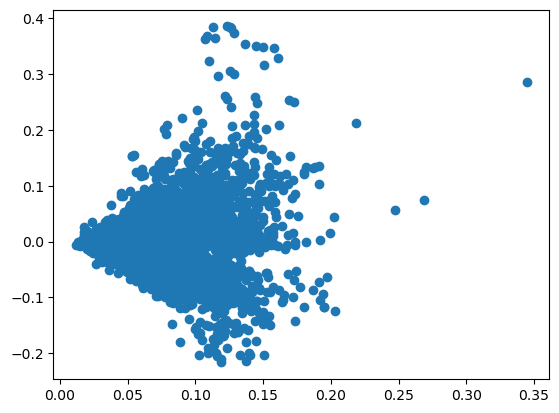

In [16]:
lsa(tf_idf_matrix)

In [17]:
def plot_2d_projection(projected_data, title, doc_labels, unique_groups):
    """
    Plots the data using the labels generated during loading.
    """
    # Create a color map: {'rec.autos': 0, 'rec.motorcycles': 1, ...}
    # We use the unique_groups list to ensure colors are consistent between plots
    label_to_id = {name: i for i, name in enumerate(unique_groups)}
    
    # Convert string labels (e.g. 'rec.autos') to integer IDs (e.g. 0)
    color_indices = [label_to_id[label] for label in doc_labels]

    # Setup Plot
    fig, ax = plt.subplots(figsize=(8,4))
    
    # Scatter plot
    scatter = ax.scatter(projected_data[:, 0], projected_data[:, 1], 
                         c=color_indices, 
                         cmap='tab10', 
                         alpha=0.5, 
                         s=15)

    # Create Legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', 
                          markerfacecolor=plt.cm.tab10(i/(len(unique_groups)-1) if len(unique_groups)>1 else 0), 
                          label=name, markersize=10) 
               for i, name in enumerate(unique_groups)]
    
    ax.legend(handles=handles, title="Newsgroup")
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("SVD Component 1")
    ax.set_ylabel("SVD Component 2")
    ax.grid(True, alpha=0.3)
    
    plt.show()

In [18]:
def svd(tf_idf_matrix, doc_labels, unique_groups):
    """
    Runs SVD twice and plots using the explicit doc_labels list.
    """
    svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)

    # Plot before normalizing norms
    print("Running SVD on RAW data")
    X_raw = svd.fit_transform(tf_idf_matrix)
    plot_2d_projection(X_raw, "SVD on Raw TF-IDF", doc_labels, unique_groups)
    
    # Plot after normalizing norms
    print("Normalizing and running SVD on L2-Normalized TF-IDF")
    X_norm = normalize(tf_idf_matrix, norm='l2', axis=1)
    X_projected = svd.fit_transform(X_norm)
    plot_2d_projection(X_projected, "SVD on L2-Normalized TF-IDF", doc_labels, unique_groups)

    return X_projected

Running SVD on RAW data


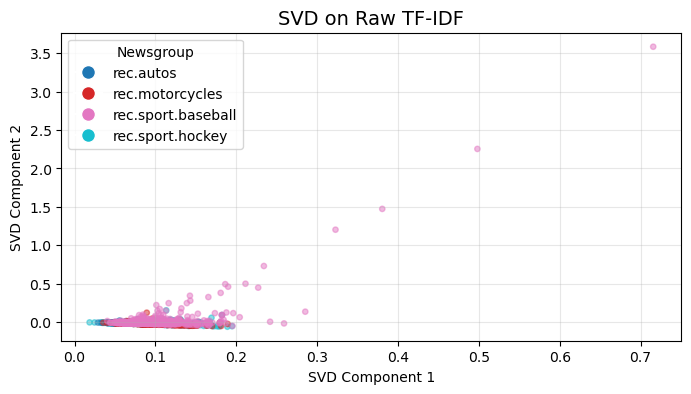

Normalizing and running SVD on L2-Normalized TF-IDF


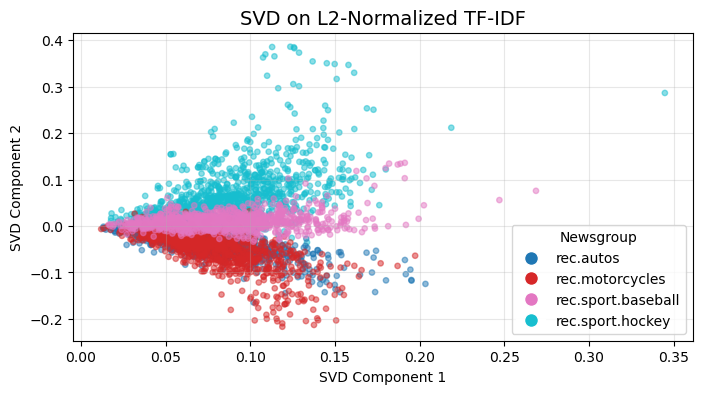

In [19]:
svd_projections = svd(tf_idf_matrix, doc_labels, NEWSGROUPS)

### Analysis of Semantic Projection

**The "Vehicle" vs. "Sport" Spectrum**    
There is a discernible semantic gradient along the Y-axis (Component 2). Hockey documents appear at the top, while motorcycle documents sit at the bottom. The SVD algorithm identified that the biggest contrast in the vocabulary is between "hockey" words and "motorcycle" words. Understandably, car documents cluster almost on top of motorcycles, which makes sense. Meanwhile, baseball documents sit in the middle. This suggests that "Component 2" is not capturing baseball-specific terms. Baseball documents are "neutral" regarding the specific hockey vs motorcycle contrast defined by the vertical axis.

**The Fan Shape**   
The data points form a fan shape spreading out from the left side. The dense overlap on the far left represents documents that are likely short or use mostly generic words. As you move to the right, the documents likely become longer or richer in specific jargon. These stronger documents push further outward, where the separation between topics becomes much clearer.

**Dimensionality Limitations**  
The plot also reveals the limits of using only two dimensions. It seems like two axes are not quite enough to separate them all perfectly. While the vehicle and hockey groups separate well, the baseball documents appear squashed in the middle. If we added a third dimension, the baseball cluster would likely pop out along that new axis, separating it clearly from the others. However, the visible overlap in the plot also reflects the genuine shared vocabulary between these related fields.

## t-SNE

Let's use the t-distributed stochastic neighbor embedding (t-SNE) method to reduce the TFIDF vectors of the documents to two dimensions. This way we will see if distinct clusters emerge more clearly than in the linear SVD projection. 

Let's first try t-SNE directly on the raw TF-IDF vectors.


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.321156
[t-SNE] KL divergence after 250 iterations with early exaggeration: 114.739212
[t-SNE] KL divergence after 1000 iterations: 2.398167
Saved figure to results/figures/tsne_naive_raw_sparse.png


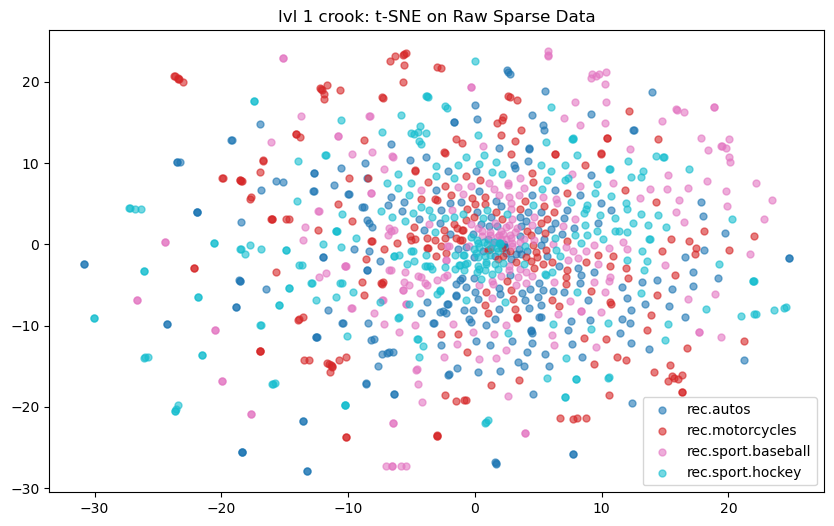

In [22]:
subset_size = 1000
numpy.random.seed(42) # Ensure same subset for both plots
indices = numpy.random.choice(len(documents), min(len(documents), subset_size), replace=False)

X_subset = tf_idf_matrix[indices]
labels_subset = [doc_labels[i] for i in indices]

# init='random' to simulate a true naive attempt
tsne_naive = TSNE(n_components=2, verbose=1, perplexity=40, random_state=42, init="random", learning_rate='auto')
X_embedded_naive = tsne_naive.fit_transform(X_subset)

plt.figure(figsize=(10, 6))
unique_labels = sorted(list(set(labels_subset)))
colors = plt.cm.tab10(numpy.linspace(0, 1, len(unique_labels)))

for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(labels_subset) if l == label]
    plt.scatter(X_embedded_naive[idxs, 0], X_embedded_naive[idxs, 1], 
                label=label, color=colors[i], alpha=0.6, s=25)

plt.title("lvl 1 crook: t-SNE on Raw Sparse Data")
plt.legend()
plt.savefig(
    "results/figures/tsne_naive_raw_sparse.png",
    dpi=300,
    bbox_inches="tight"
)
print("Saved figure to results/figures/tsne_naive_raw_sparse.png")
plt.show()

### t-SNE interpretation

This "blob" shape seems like a pretty even steven mix. I think it is because the text data is so high-dimensional. Because TF-IDF vectors are very sparse (mostly zeros), calculating Euclidean distances between documents becomes difficult, often causing points to clump together in the center, like in this case.

The lack of clear separation compared to the SVD plot highlights a key trade-off. SVD is excellent at capturing global variance (e.g. the "Sports vs. Vehicles" axis). t-SNE, by prioritizing local neighbors, seems to struggle to organize distinct global clusters in this case when the shared vocabulary between topics is significant.

**HOWEVER**, using a SVD/PCA based initialization might help unfold these clusters more effectively.

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.039526
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.830353
[t-SNE] KL divergence after 1000 iterations: 1.185953
Saved figure to results/figures/tsne_svd_reduced.png


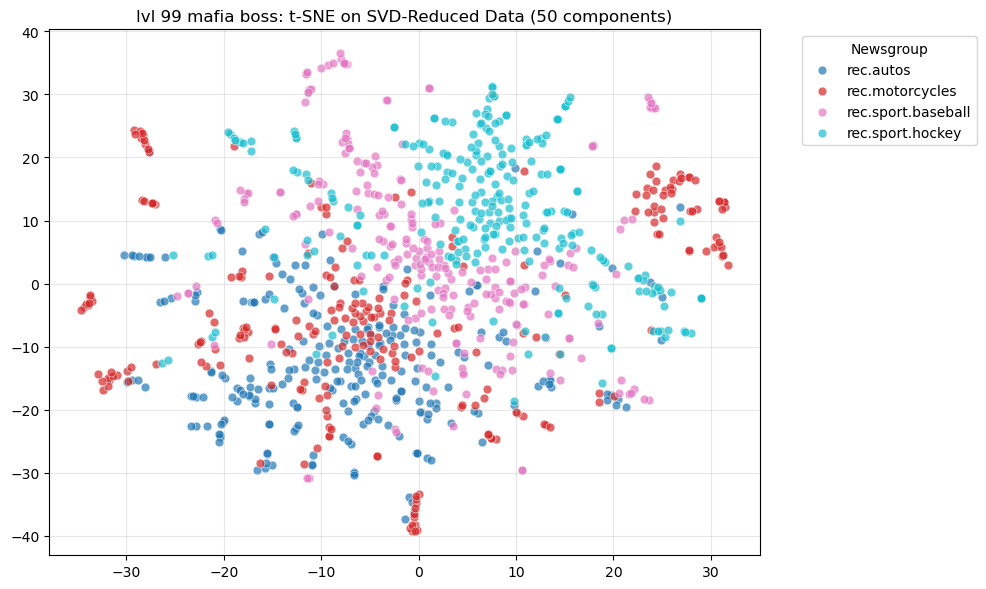

In [23]:
# reduce dimensions first (LSA)
# we project the SAME subset down to 50 dense latent features
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
X_dense = svd.fit_transform(X_subset)

# run t-SNE on DENSE data
# init='pca' to help preserving global structure
tsne_refined = TSNE(n_components=2, verbose=1, perplexity=40, random_state=42, init="pca", learning_rate='auto')
X_embedded_refined = tsne_refined.fit_transform(X_dense)

plt.figure(figsize=(10, 6))

for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(labels_subset) if l == label]
    plt.scatter(X_embedded_refined[idxs, 0], X_embedded_refined[idxs, 1], 
                label=label, color=colors[i], alpha=0.7, s=40, edgecolor='w', linewidth=0.5)

plt.title("lvl 99 mafia boss: t-SNE on SVD-Reduced Data (50 components)")
plt.legend(title="Newsgroup", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.savefig(
    "results/figures/tsne_svd_reduced.png",
    dpi=300,
    bbox_inches="tight"
)
print("Saved figure to results/figures/tsne_svd_reduced.png")
plt.show()

## Conclusion & Final Thoughts

The contrast between the two experiments highlights the importance of preprocessing in manifold learning.

By first reducing the noise with SVD (down to 50 dense components), t-SNE was able to successfully "unfold" the data. We now see clear islands of data. For example, the hockey (cyan) group has separated clearly to the right/top-right.

Also interesting how autos (blue) and motorcycles (red) cluster near each other (bottom-left), reflecting their shared mechanical vocabulary. Similarly, baseball (pink) sits closer to the Hockey cluster than to the vehicles.

Noise reduction has been achieved! The dense fog of overlapping points in the center has largely cleared, meaning the model has successfully filtered out generic, non-informative words to focus on topically relevant jargon.